In [351]:
from pathlib import Path
import numpy as np
import pandas as pd

In [352]:
import matplotlib.pyplot as plt

In [353]:
from sklearn.decomposition import PCA
from sklearn.svm  import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler

In [354]:
PATH_CARDS = '/home/jcscabral/Studies/UspEsalq/Tcc/projeto/pesquisa/code/R/swipecards'
MAX_VARIABLES = 160
pathfiles = [p for p in Path(PATH_CARDS).iterdir()]    

In [355]:
def norm_data(X):
    
    Xn = (X.iloc[:,3:] - X.iloc[:,3:].mean())/X.iloc[:,3:].std()
    Xn.fillna(0, inplace=True)
    
    #rearrange columns
    Xn["user_id"] = X["user_id"].values 
    Xn["swipe_number"] = X["swipe_number"].values 
    Xn["action_number"] = X["action_number"].values 
    cols = np.concatenate([Xn.columns.values[-3:], Xn.columns.values[:-3]])
    Xn = Xn[cols] 
       
    return Xn

In [356]:
def stand_data(X):

    columns = X.columns.values
    cols = np.concatenate([columns[:-3], columns[-3:]])
    Xnum = X.iloc[:,3:]

    Xnum = Xnum / np.std(Xnum.values, axis=0)

    Xnum["user_id"] = X["user_id"].values 
    Xnum["swipe_number"] = X["swipe_number"].values 
    Xnum["action_number"] = X["action_number"].values

    return Xnum[cols]

In [236]:
def min_max(X):

    columns = X.columns.values
    Xnum = X.iloc[:,3:]    

    scaler = MinMaxScaler()
    scaler.fit(Xnum)
    Xnum = scaler.transform(Xnum)

    Xminmax = pd.DataFrame(Xnum, columns = columns[3:])

    Xminmax["user_id"] = X["user_id"].values 
    Xminmax["swipe_number"] = X["swipe_number"].values 
    Xminmax["action_number"] = X["action_number"].values

    cols = np.concatenate([columns[:-3], columns[-3:]])
    
    return Xminmax[cols]


In [117]:
def split_train_test(X, not_num = True, n = 2):
    
    # 4 train | 1 test
    start = 1
    end = 5

    for _ in range(n):    
        train = X[(X["action_number"] >= start) &
                  (X["action_number"] < end)]
        test = X[X["action_number"] == end]

        start += 1        
        end += 1
        if not_num:
            yield train, test
        else:
            yield train.iloc[:,3:], test.iloc[:,3:]
        

In [118]:
# def template_data(X, not_num = True, n = 2):
    
#     start = 1
#     end = 6

#     for _ in range(n):    
#         data = X[(X["action_number"] >= start) &
#                   (X["action_number"] < end)]        

#         start += 1        
#         end += 1
#         if not_num:
#             yield data
#         else:
#             yield data.iloc[:,3:]

In [245]:
def session_data(X):    
    for i in range(7):        
        action_number = i +1
        yield X[X["action_number"] == action_number]

In [246]:
# def pca_data(Xbase, Xtest, n_components):
#     pca = PCA(n_components = n_components)
#     Xpca = pca.fit_transform(Xbase)
#     Xtransf  = pca.transform(Xtest)
#     return Xpca, Xtransf

### Exploratory Analysys

In [301]:
#pathfiles[11] #62
#pathfiles[35] #52
#pathfiles[48] #41

In [302]:
i = 11
path = pathfiles[i]
df62 = pd.read_csv(path, index_col=0)

i = 35
path = pathfiles[i]
df52 = pd.read_csv(path, index_col=0)

i = 48
path = pathfiles[i]
df41 = pd.read_csv(path, index_col=0)

In [372]:
df62


,user_id,action_number,swipe_number,ps_fs,ps_ls,ps_md,ps_fq,ps_tq,ps_ir,ps_am,...,ay_rg,ay_sk,ay_ku,dp_mg,dp_ec,dp_ang,dp_avang,dp_ra,tm_dr,tm_fl
1,62,1,1,0.068864,0.032234,0.038584,0.032234,0.050916,0.018681,0.044567,...,0.001594,-0.750000,-1.687500,488.354997,333.337667,-0.045015,0.000000,0.682572,8,0
2,62,1,2,0.055678,0.030037,0.042857,0.036447,0.049267,0.012821,0.042857,...,0.000000,0.000000,0.000000,911.653443,0.000000,0.000000,0.000000,0.000000,49,0
3,62,1,3,0.052503,0.032234,0.059829,0.055189,0.064347,0.009158,0.056455,...,0.008212,0.871529,-0.687524,865.109291,482.050827,-0.014522,-0.013246,0.557214,13,0
4,62,1,4,0.050794,0.029792,0.063736,0.058852,0.066667,0.007814,0.060781,...,0.007160,-0.235459,-0.951549,1104.362686,437.504286,-0.048018,0.000000,0.396160,16,0
5,62,1,5,0.067155,0.032479,0.049817,0.041148,0.058486,0.017338,0.049817,...,0.000000,0.000000,0.000000,526.277493,0.000000,0.000000,0.000000,0.000000,58,0
6,62,2,6,0.057143,0.027839,0.062515,0.057448,0.066911,0.009463,0.059785,...,0.006108,-0.102053,-1.288224,1433.891591,456.858840,-0.061327,0.000000,0.318615,8,0
7,62,2,7,0.065446,0.034676,0.064957,0.055067,0.067399,0.012332,0.059487,...,0.039417,-1.034729,-0.217664,1026.319619,423.398158,-0.106484,0.144013,0.412540,13,0
8,62,2,8,0.063980,0.031013,0.069597,0.062393,0.071429,0.009035,0.065608,...,0.017580,-0.745715,-0.329330,1424.061816,492.544414,-0.101689,0.000000,0.345873,8,0
9,62,2,9,0.067643,0.036874,0.052259,0.044567,0.059951,0.015385,0.052259,...,0.000000,0.000000,0.000000,859.211266,0.000000,0.000000,0.000000,0.000000,65,0
10,62,2,10,0.050794,0.030769,0.062882,0.052320,0.073199,0.020879,0.060003,...,0.023109,-0.714370,-0.406581,780.180258,398.017588,-0.158953,0.127587,0.510161,6,0


In [305]:
df62.head(1)

,user_id,action_number,swipe_number,ps_fs,ps_ls,ps_md,ps_fq,ps_tq,ps_ir,ps_am,...,ay_rg,ay_sk,ay_ku,dp_mg,dp_ec,dp_ang,dp_avang,dp_ra,tm_dr,tm_fl
1,62,1,1,0.068864,0.032234,0.038584,0.032234,0.050916,0.018681,0.044567,...,0.001594,-0.75,-1.6875,488.354997,333.337667,-0.045015,0.0,0.682572,8,0


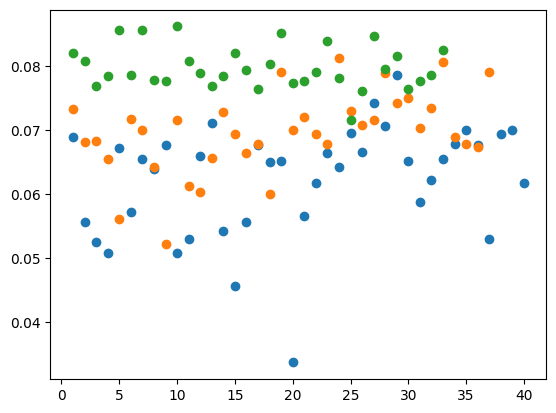

In [332]:
plt.scatter(df62['swipe_number'], df62['ps_fs'])
plt.scatter(df52['swipe_number'], df52['ps_fs'])
plt.scatter(df41['swipe_number'], df41['ps_fs'])
plt.show()

In [ ]:
attackdata = norm_data(df52)
atacksess = attackdata[(attackdata['action_number']< 6)]
attack_sess_test = attackdata[(attackdata['action_number'] == 2)]

In [ ]:
userdata = min_max(df62)
sessions = userdata[(userdata['action_number']< 6)]
sess_test = userdata[(userdata['action_number'] == 6)]

In [ ]:
n_cmp = 20
pca = PCA(n_components = n_cmp)
pcaA = pca.fit_transform(sessions[3:])
pcaA.shape


In [ ]:
pca.explained_variance_

In [ ]:
pca.score(sess_test)

### GridSearch "vanilla"

<p>Scenario in real world:</p>

<p>Train/test with five sessions. Next session validates the tempĺate</p>
<p>DAKOTA transforms 126 features into 30-70 new ones.</p>
<p>Here with 280 features, stands from 10 to 160.</p> 

In [121]:
# def grid_search_svm_one(X):
    
#     '''
#     Receives PCA data train and test
#     '''
#     gamma = 1.0e-7
#     nus = np.arange(0.001, 1, step = 0.01)

#     df = pd.DataFrame(columns=["nu", "score"])
#     for i, nu in enumerate(nus):
#         #svm =  OneClassSVM(gamma = gamma, kernel = "rbf", nu = nu)
#         svm =  OneClassSVM(gamma = gamma, kernel = "poly", nu = nu)
#         model = svm.fit(X)
#         results = model.predict(X)
#         score = results[results==1].shape[0]/results.shape[0] # true positives
#         df.loc[i] = {"nu": nu, "score": score}
    
#     index = df["score"].idxmax()
#     dfbest = df.iloc[index]
#     score = dfbest["score"]
#     best_nu = dfbest["nu"]
#     svm =  OneClassSVM(gamma = gamma, kernel = "rbf", nu = best_nu)
#     model = svm.fit(X)

#     return model, best_nu, score  

In [357]:
def grid_search_svm(Xtrain, Xtest):
    
    '''
    Receives PCA data train and test
    '''
    
    gamma = 1.0e-7
    nus = np.arange(0.001, 1, step = 0.01)

    df = pd.DataFrame(columns=["nu", "score"])
    for i, nu in enumerate(nus):
        svm =  OneClassSVM(gamma = gamma, kernel = "rbf", nu = nu)
        model = svm.fit(Xtrain)
        results = model.predict(Xtest)
        score = results[results==1].shape[0]/results.shape[0] # true positives
        df.loc[i] = {"nu": nu, "score": score}
    
    index = df["score"].idxmax()
    dfbest = df.iloc[index]
    score = dfbest["score"]
    best_nu = dfbest["nu"]
    svm =  OneClassSVM(gamma = gamma, kernel = "rbf", nu = best_nu)
    model = svm.fit(Xtrain)

    return model, best_nu, score  
    

### User x user

##### 0) Data from template w/ 5 sessions

In [358]:
# set data structure to append the results
results = pd.DataFrame(columns=["id", "cmp", "tpl", "nu", "score"])
models = {}

In [359]:
df_id = 0
for path in pathfiles:
    
    df = pd.read_csv(path, index_col=0)
    id = np.unique(df["user_id"].values)[0]
    
    tpl = 1 # template number
    templates = list()    
    for Xtrain, Xtest in split_train_test(df):
        
        _Xtrain = min_max(Xtrain)
        _Xtrain = _Xtrain.iloc[:,3:]

        _Xtest = min_max(Xtest)
        _Xtest = _Xtest.iloc[:,3:]

        n_m = _Xtrain.shape[0]        
        end_c = min(n_m, MAX_VARIABLES)
        n_components = np.arange(10, end_c)

        tpl_score = 0.0
        tpl_cmp = 0        
        template = {}
        for n_cmp in n_components:            
            
            pca = PCA(n_components = n_cmp)
            Xpca = pca.fit_transform(_Xtrain)
            Xtra  = pca.transform(_Xtest)
            
            model, nu, score = grid_search_svm(Xpca, Xtra)
            if score > tpl_score:                        
                template = {"tpl": tpl, "cmp": n_cmp, "pca": pca, "model": model}
                tpl_score =  score

            results.loc[df_id] = {"id": id, "tpl": tpl, "cmp": n_cmp,
                                "nu": nu, "score": score}
            df_id += 1    
        templates.append(template)
        tpl += 1    

    models[id] = templates

In [ ]:
np.unique(results["id"].values)

In [361]:
group_results = results.groupby(["id", "tpl"])
group_results

In [362]:
indxmax =  group_results["score"].idxmax()

In [363]:
best_results = results.iloc[indxmax]
best_results.head(5)

,id,cmp,tpl,nu,score
1110,1,10,1,0.451,0.833333
1120,1,10,2,0.051,0.600000
1213,2,10,1,0.551,0.750000
1236,2,10,2,0.871,0.750000
653,3,10,1,0.041,1.000000


In [364]:
best_results["cmp"].min(), best_results["cmp"].max()

(10, 10)

In [365]:
# It's not a real scenario. Overfitting data
THRESHOLD = 0.5
TP = best_results[best_results['score']>THRESHOLD].shape[0]/best_results.shape[0]
FN = 1 - TP
TP, FN

(0.9230769230769231, 0.07692307692307687)

##### 1) Scenario: Real authentication

In [366]:
auth_results = pd.DataFrame(columns=["id", "cmp", "tpl", "score"])
TEMPLATE_SESSIONS = 5
j = 0
for path in pathfiles:
    
    df = pd.read_csv(path, index_col=0)    
    id = np.unique(df["user_id"].values)[0]    
    dic_model = models[id]    
    
    for t in range(0,2):

        X = df[df["action_number"] == TEMPLATE_SESSIONS + t + 1]
        
        _Xval = min_max(X)
        _Xval = _Xval.iloc[:,3:]
        
        n_cmp = dic_model[t]['cmp']
        model = dic_model[t]['model']
        pca = dic_model[t]['pca']
        Xval_pca = pca.transform(_Xval)
        
        results = model.predict(Xval_pca)
        score = results[results==1].shape[0]/results.shape[0] # true positives
        auth_results.loc[j] = {"id": id, "tpl": t + 1,
                               "cmp": n_cmp, "score": score}
        j +=1

In [ ]:
# auth_results = pd.DataFrame(columns=["id", "cmp", "tpl", "score"])

# j = 0
# for path in pathfiles:
    
#     df = pd.read_csv(path, index_col=0)    
#     id = np.unique(df["user_id"].values)[0]    
#     dic_model = models[id]
#     #dfnorm = norm_data(df)   
    
#     i = 0
#     for Xtrain, Xtest in split_train_test(df, not_num=True):
        
#         _Xtrain = norm_data(Xtrain)
#         _Xtrain = _Xtrain.iloc[:,3:]

#         _Xtest = norm_data(Xtest)
#         _Xtest = _Xtest.iloc[:,3:]
    
#         tpl = i + 1
#         n_cmp = dic_model[i]['cmp']
#         model = dic_model[i]['model']

#         _ , Xtest_pca = pca_data(_Xtrain, _Xtest, n_cmp)                

#         results = model.predict(Xtest_pca)
#         score = results[results==1].shape[0]/results.shape[0] # true positives
#         auth_results.loc[j] = {"id": id, "tpl": tpl,
#                                "cmp": n_cmp, "score": score}         
#         i += 1
#         j += 1
   

True Positives
False Negatives

In [367]:
THRESHOLD = 0.5
TP = auth_results[auth_results['score']>THRESHOLD].shape[0]/auth_results.shape[0]
FN = 1 - TP
TP, FN

(0.7788461538461539, 0.22115384615384615)

In [161]:
auth_results.to_csv('swipe_userxuser.csv')

##### 2) All x user by all sections

In [368]:
results_all = pd.DataFrame(columns=["id", "id_attack", "tpl", 
                                    "section", "tn", "sz"])

df_id = 0
for path in pathfiles:    
    
    df = pd.read_csv(path, index_col=0)
    id = np.unique(df["user_id"].values)[0]
    dic_model = models[id]
    

    npfiles = np.array(pathfiles)
    npfiles_attack = npfiles[npfiles != path]
    
    for t in range(0, 2):        
        
        n_cmp = dic_model[t]['cmp']
        model = dic_model[t]['model']
        pca = dic_model[t]['pca']        
    
        for file_attack in npfiles_attack:

            df_attack = pd.read_csv(file_attack, index_col=0)
            id_attack = np.unique(df_attack["user_id"].values)[0]

            for s, Xattack in enumerate(session_data(df_attack)):
                
                _Xattack = min_max(Xattack) 
                _Xattack = _Xattack.iloc[:,3:]               
                Xattack_pca = pca.transform(_Xattack)                
                results = model.predict(Xattack_pca)
                
                sz = results.shape[0]
                tn = results[results==-1].shape[0] # true negative

                results_all.loc[df_id] = {"id": id, 
                                        "id_attack": id_attack,
                                        "tpl": tpl, 
                                        "section": s + 1,
                                        "tn": tn,
                                        "sz": sz}
                df_id += 1

In [369]:
results_all.shape

(37128, 6)

In [370]:
results_all.head(10)

,id,id_attack,tpl,section,tn,sz
0,49,54,3,1,0,7
1,49,54,3,2,0,9
2,49,54,3,3,0,6
3,49,54,3,4,0,6
4,49,54,3,5,0,5
5,49,54,3,6,0,6
6,49,54,3,7,0,6
7,49,24,3,1,0,4
8,49,24,3,2,1,4
9,49,24,3,3,1,5


In [371]:
results_all['tn'].sum() / results_all["sz"].sum()


0.16851831122553684

In [241]:
results_all.to_csv('swipe_userxall.csv')

### All against template user

In [ ]:
scores = ['precision', 'recall']
for score in scores: 
    search  = GridSearchCV(OneClassSVM(), tuned_parameters, cv=10,
                           scoring='%s_macro' % score, return_train_score=True)
    search.fit(Xpca)
    
    #resultDf = pd.DataFrame(search.cv_results_)
    #print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(search.cv_results_)

In [11]:
pipe = Pipeline(steps=[("pca", pca), "svm", svm])


In [12]:
param_grid = {
    "pca__n_components": [30, 40, 50, 60, 70]
}

In [20]:
search  = GridSearchCV(pipe, param_grid= param_grid, n_jobs= 2)

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'tuned_parameters'

In [ ]:
splits = KFold(n_splits=5).split(X)

In [19]:
search.fit(X, X)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator Pipeline(steps=[('pca', PCA(n_components='mle')), 'svm',
                OneClassSVM(gamma='auto')]) does not.

In [285]:
pathfile = pathfiles[0]
print(pathfile)

/home/jcscabral/Studies/UspEsalq/Tcc/projeto/pesquisa/code/R/swipecards/card49.csv


In [167]:
X =  pd.read_csv(pathfile, index_col=0)
X.shape

(52, 283)

In [134]:
X.head()

,user_id,action_number,swipe_number,ps_fs,ps_ls,ps_md,ps_fq,ps_tq,ps_ir,ps_am,...,ay_rg,ay_sk,ay_ku,dp_mg,dp_ec,dp_ang,dp_avang,dp_ra,tm_dr,tm_fl
1,55,1,1,0.059585,0.037851,0.059585,0.057631,0.065446,0.007814,0.059604,...,0.012787,0.377864,-1.286558,1706.729543,504.892068,0.059454,0.000000,0.295824,15,0
2,55,1,2,0.060562,0.035165,0.064103,0.061111,0.069353,0.008242,0.060073,...,0.025736,0.521633,-1.393238,1321.616549,399.405809,0.045082,-0.080144,0.302210,15,0
3,55,1,3,0.055433,0.040781,0.066911,0.048107,0.068254,0.020147,0.058538,...,0.019428,0.359178,-1.557358,976.216914,330.945615,0.075613,-0.116659,0.339008,15,0
4,55,1,4,0.060806,0.035409,0.048107,0.041758,0.054457,0.012698,0.048107,...,0.000000,0.000000,0.000000,880.160213,0.000000,0.000000,0.000000,0.000000,97,0
5,55,1,5,0.052259,0.038584,0.063004,0.059829,0.065568,0.005739,0.061775,...,0.093586,4.423592,20.103405,2816.120776,539.334775,0.035236,0.000000,0.191517,17,0


In [138]:
Xtrain = X[X["swipe_number"] < 6]
Xtrain["swipe_number"].unique

<bound method Series.unique of 1    1
2    2
3    3
4    4
5    5
Name: swipe_number, dtype: int64>

In [139]:
Xtest = X[X["swipe_number"] == 6]
Xtest["swipe_number"].unique

<bound method Series.unique of 6    6
Name: swipe_number, dtype: int64>

In [140]:
Xval = X[X["swipe_number"] == 7]
Xval["swipe_number"].unique

<bound method Series.unique of 7    7
Name: swipe_number, dtype: int64>

In [7]:
# Normalization
Xn = (X.iloc[:,2:] - X.iloc[:,2:].mean())/X.iloc[:,2:].std()

In [291]:
# Standardization (worst perfomance)
#Xn  = (X.iloc[:,2:] -  (X.iloc[:,2:]).min()) / ((X.iloc[:,2:]).max() - (X.iloc[:,2:]).min())

In [9]:
Xn['user_id'] = X["user_id"] 
Xn['swipe_number'] = X["swipe_number"] 

/tmp/ipykernel_319968/1606918020.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xn['user_id'] = X["user_id"]
/tmp/ipykernel_319968/1606918020.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Xn['swipe_number'] = X["swipe_number"]


In [10]:
cols = np.concatenate([Xn.columns.values[-2:], Xn.columns.values[:-2]])

In [11]:
Xn = Xn[cols]

In [12]:
Xn.fillna(0, inplace=True)

In [13]:
# first five sessions

Xtrain  = Xn[Xn["swipe_number"] <=41]

In [14]:
Xtrain = Xtrain.iloc[:,2:] 

In [50]:
Xtrain.shape

(41, 280)

In [16]:
pca = PCA()
Xpca = pca.fit_transform(Xtrain)

In [51]:
Xpca.shape

(41, 41)

In [17]:
Xtest  = Xn[(Xn["swipe_number"] >41) & (Xn["swipe_number"] <48)]

In [18]:
Xtest = Xtest.iloc[:,2:] 

In [49]:
Xtest.shape

(6, 280)

In [19]:
Xtransf  = pca.transform(Xtest)

In [48]:
Xtransf.shape

(6, 41)

In [20]:
svm =  OneClassSVM(gamma = 1.0e-7, kernel="rbf", nu=0.1)

In [111]:
model = svm.fit(Xpca)
model

OneClassSVM(gamma=1e-07, nu=0.001)

In [22]:
results = model.predict(Xpca)
results

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1, -1])

In [23]:
results[results==1].shape[0], results[results==-1].shape[0]

(32, 9)

In [24]:
svm.score_samples(Xpca)

array([4.09991406, 4.09992503, 4.09992009, 4.09983713, 4.09981922,
       4.09987028, 4.09982766, 4.09989281, 4.09986248, 4.09985626,
       4.09988872, 4.09982903, 4.09985487, 4.09989683, 4.09980536,
       4.09988387, 4.09984858, 4.09982408, 4.09986194, 4.09982349,
       4.09975219, 4.09985403, 4.09986727, 4.09982284, 4.0998931 ,
       4.09992491, 4.09979999, 4.09980347, 4.09955329, 4.09981595,
       4.09985165, 4.09974829, 4.09990628, 4.09989999, 4.09983396,
       4.09983102, 4.09988856, 4.099897  , 4.09990428, 4.09990186,
       4.09978332])

In [29]:
results = model.predict(Xtransf)
results

array([-1,  1,  1,  1,  1, -1])

In [28]:
svm.score_samples(Xtransf)

array([4.09981798, 4.09985134, 4.09983998, 4.09988365, 4.09989666,
       4.09976309])

In [97]:
nus = np.arange(0.001, 1, step = 0.01)
tuned_parameters = {'kernel' : ['rbf'], 'nu': nus}